<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 4 - Appliquer la méthode supervisée</span>

<span style="color:orange;font-size:1.5em;font-weight:bold">Cas supervisé + semi supervisé</span>

On va traité dans un premier temps un modèle supervisé puis on l'utilisera comme initialisation pour le SSL (remplace le cluster)

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import copy

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [ ]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import BrainCancerClassifier
from notebooks.utils.training import Trainer, SslManager


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
# N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# # en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# # et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10
EXPERIMENT_NAME = "experiment_01"

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet18",
    # "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":str(DEVICE),
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow">Entrainement supervisée: Entrainer seulement sur le jeu fortement labellisé</span>

La méthode supervisée revient à faire de la classification en guidant le modèle via les images labellisées

- X sera donc composé des chemins des images (Series!) et y sera formé par les labels.
- On se constitue un jeu d'entrainement augmenté et un jeu de validation
- On créé les loaders
- On entraine le modèle en relevant les métriques d'intérêt

<span style="color:purple;font-weight:bold">Entrainement supervisé</span>

In [9]:
# gestionnaire de sauvegarde
supervised_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="supervised"
)

In [ ]:
supervised_config = project_config | {
    "num_classes":1,
    "supervised_n_epoch":N_EPOCH*3,
    "supervised_learning_rate":1e-4,
}

In [11]:
# juste par confort
X = avec_labels_path
y = avec_labels_encoding

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [12]:
# Datasets & Loaders

# Instanciation de l'objet de redim, norm, augmentation
base_transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE)

# Constitution des sets d'entrainement augmentés et de validation non augmenté
train_dataset = ImagesToDataset(X_train, y_train, transform=base_transform.preproc(train=True))
test_dataset = ImagesToDataset(X_test, y_test, transform=base_transform.preproc(train=False))

# Loader des sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Instanciation du modèle et configuration de la pipeline d'entrainement

# Instanciation du classificateur + déplacement sur le device
model_classif = BrainCancerClassifier(
    num_classes=1, 
    model_name=supervised_config['model']
).to(DEVICE)
# L'optimiseur ajuste les poids du modèle. Contient le learning_rate et les gradients.
# On met un learning rate (lr) faible car fine-tuning 
# (on ne veut pas détruire ce que ResNet sait déjà).
optimizer = optim.Adam(
    model_classif.parameters(), 
    lr=supervised_config["supervised_learning_rate"]
)
# On instancie la loss (sans poids car dataset équilibré)
# criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit
# on a 50 images saines et 50 cancer du coup pos_weight ici vaut 1 mais en
# supposant une répartition plus commune (plus de sain que non)
num_sains = y_train.count(0)
num_cancers = y_train.count(1)
# Calcul du ratio (poids pour la classe positive)
# On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Instanciation de la pipeline de training
trainer = Trainer(
    model_classif, 
    DEVICE, 
    criterion, 
    optimizer
)

In [ ]:
# Boucle d'entraînement
temp_best_f2 = 0.0
temp_best_prauc = 0.0
temp_best_ece = 1.0
print("====== Entraînement Supervisé (100 images) ==========")
for epoch in range(supervised_config['supervised_n_epoch']):
    # ================= ENTRAINEMENT ================
    train_loss = trainer.train_epoch(train_loader) # on entraine sur le 80 images labellisées
    
    # ====================== EVAL =====================
    results = trainer.eval_metrics(test_loader) # on evalue sur les 20 images restantes label
    ece = trainer.calculate_ece(results['raw_data']) #type:ignore On estime la fiabilité de la confiance
    print(
        f"Epoch {epoch+1}/{supervised_config['supervised_n_epoch']} | Loss: {train_loss:.4f}"
        f" | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}"
    )
    
    # ================= SAUVEGARDE INDIVIDUELLE DES MÉTRIQUES =============
    temp_metrics ={
            "epoch" : epoch+1,
            "train_loss" : train_loss,
            # "f2" : results["f2"],
            # "precision" : results["precision"],
            # "recall":results["recall"],
            "ece":ece, # Fiabilité de la confiance du modèle
            # "accuracy": results["accuracy"], # Exactitude
            # "auc": results["auc"],# Capacité a séparer les labels
            # "pr_auc": results["pr_auc"], # Précision sur les positifs
            **{key: value for key, value in results.items()}
        }
    supervised_manager.log_metrics(temp_metrics)
    
    # ================ CHECKPOINT (SAVE SI MEILLEUR MODELE JUSQU'ICI) ===========
    temp_f2 = results["f2"]
    temp_prauc = results['pr_auc']
    
    if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
        if ece <= temp_best_ece*1.25:
            
            # réalise un checkpoint
            supervised_manager.save_checkpoint({
                'epoch': epoch + 1,
                'train_loss':train_loss,
                'state_dict': model_classif.state_dict(), # ou plus rigoureux: trainer.model.state_dict()
                'optimizer': optimizer.state_dict(),# ou plus rigoureux: trainer.optimizer.state_dict()
                'f2': temp_f2,
                'pr_auc': temp_prauc,
                "ece":ece,
                'config': supervised_config
            },is_best=True)
            
            # MAJ des métriques
            temp_best_f2 = max(temp_f2, temp_best_f2)
            temp_best_prauc = temp_prauc
            temp_best_ece = ece

====== Entraînement Supervisé (100 images) ==========
Epoch 1/20 | Loss: 0.6902 | f2: 0.4444 | pr_auc: 0.7665 | ece: 0.0991
Epoch 2/20 | Loss: 0.6277 | f2: 0.6383 | pr_auc: 0.9049 | ece: 0.2088
Epoch 3/20 | Loss: 0.5791 | f2: 0.8491 | pr_auc: 0.9588 | ece: 0.1926
Epoch 4/20 | Loss: 0.5737 | f2: 0.8491 | pr_auc: 0.9625 | ece: 0.3995
Epoch 5/20 | Loss: 0.4990 | f2: 0.9184 | pr_auc: 0.9625 | ece: 0.2867
Epoch 6/20 | Loss: 0.4896 | f2: 0.9184 | pr_auc: 0.9667 | ece: 0.3219
Epoch 7/20 | Loss: 0.4471 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.3466
Epoch 8/20 | Loss: 0.4267 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.3203
Epoch 9/20 | Loss: 0.4333 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.2938
Epoch 10/20 | Loss: 0.3932 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.2694
Epoch 11/20 | Loss: 0.3748 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.2428
Epoch 12/20 | Loss: 0.4233 | f2: 0.9184 | pr_auc: 0.9909 | ece: 0.2854
Epoch 13/20 | Loss: 0.3539 | f2: 0.9184 | pr_auc: 0.9909 | ece: 0.1942
Epoch 14/20 | Loss: 0.3747 | f2:

**remarque**:
- temp_metrics sert a alimenter les manager (supervised, unsupervised...), il permet d'avoir un historique rapide et léger des métriques
- save_checkpoint lui va sauvegarder le gros de la structure afin de pouvoir recharger et/ou analysr le modèle par la suite, il est lourd et doit donc être correctement structuré. On y sauvegarde:
    - les poids pour le classificateur (state_dict)
    - l'état de l'optimiseur
    - la performance de référence (quelques métriques pour l'identifier, epoch/f2/pr_auc/ece)
    - la configuration

In [ ]:
# ============== MEILLEUR MODELE POUR AFFICHAGE METRIQUES ===========
# On recharge le meilleur état trouvé pour la suite (SSL)
model_path = supervised_manager.ckpt_dir / "best_model.pth"
checkpoint = torch.load(model_path)
model_classif.load_state_dict(checkpoint['state_dict'])
print(f"Meilleur modèle chargé - epoch: {checkpoint['epoch']} | f2: {checkpoint['f2']:.4f}"
    f"| pr_auc: {checkpoint['pr_auc']:.4f} | ece: {checkpoint['ece']:.4f}")

f2 et pr_auc augmentent rapidement mais ece croit aussi très fortement passant de 0.1 a 0.3, l'algorithme privilégiant l'ece s'est donc limité à l'epoch 1 malgré de très faible f2 et pr auc afin d'avoir une confiance plus importante sur les prédictions réalisée.

In [ ]:
# =============== NETTOYAGE ===============
del (train_dataset, test_dataset, train_loader,
    train_loss, results
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache(

<span style="color:purple;font-weight:bold">Entrainement Semi Supervisée: Pseudo labelling sur les images inconnues</span>

In [19]:
# gestionnaire de sauvegarde
ssl_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="ssl"
)

In [ ]:
# Me^me pre traitement sur les données non labellisées (pas de split ni d'augment evidemment)
Xu = sans_label_path
yu = [-1]*len(sans_label_path)
# dataset et loader
udataset = ImagesToDataset(Xu, yu, transform=base_transform.preproc(train=False))
uloader = DataLoader(udataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# La mise en place globale du pseudo labelling
counter = 0
max_pseudo_iteration = 10
reset = True # Si on repart d'une pipeline neuve (Cold start) ou pas (Continous Fine Tuning)
# Cold start permet d'eviter l'accumulation d'erreurs et l'oubli (stacker les biais et 
# oublier les fortement labellisés) MAIS coût d'entrainement plus elevé

# Garde fou pour éviter dérive
temp_best_f2 = checkpoint['f2'] # On repart du f2 de la baseline (supervisée)
temp_best_prauc = checkpoint['pr_auc'] # On repart de l'aucpr de la baseline (supervisée)
temp_best_ece = checkpoint['ece']
temp_ece = checkpoint['ece']
del checkpoint
gc.collect()
best_trainer_state = copy.deepcopy(trainer.model.state_dict())
stop = 0
max_stop = 5

In [ ]:
ssl_config = supervised_config | {
    "reset":reset,
    "max_pseudo_iter":max_pseudo_iteration,
    "ssl_learning_rate":1e-4,
    "init_threshold":0.95,
    "final_threshold":0.85,
    'ssl_n_epoch':N_EPOCH,
}

ssl_manager.save_config(ssl_config)

# # décroissance du threshold, on assoupli le threshold a mesure des iterations
decay = np.linspace(
    ssl_config["init_threshold"],
    ssl_config["final_threshold"],
    max_pseudo_iteration+1
)


In [ ]:
while counter <= max_pseudo_iteration:
    # On s'assure que le threshold est bon
    trainer.threshold = decay[counter]
    
    # ======== PRÉDICTION SUR SET INCONNU ET GET DES PSEUDO LABELS/PATHS =========
    # IMPORTANT: AVANT D'ETRE ECRASE, ON RECOLTE PSEUDO_X ET Y! CE N'EST PAS ULOADER QUI DOIT
    # ETRE MAJ MAIS TRAINER QUI SERA MODIFIE (NOUVEAU PSEUDO_X ET PSEUDO_Y) AVANT SON RESET.
    # MODEL_CLASSIF ET OPTIMIZER DE LA PARTIE SUPERVISÉE ONT POUR SEULE UTILITÉ INFLUENCÉ TRAINER
    print(f"=== iter {counter} | pseudo labelling (seuil {decay[counter]:.4f}) ===")
    pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
    print(f"Pseudo-labels générés : {len(pseudo_X)}")
    
    # ============= EMPECHE BOUCLE INUTIE ET DERIVE IMPORTANTE =================
    if len(pseudo_X) == 0 or temp_ece >= 0.5: # Ajout de l'ece pour eviter le biais de confirmation
        print("Confiance rompue pour relancer l'entrainement")
        break
    
    
    # ========== MISE EN PLACE DU DATALOADER ================ 
    # (On NE STACK PAS les pseudo et on REPART TOUJOURS du jeu labellisé de base!)
    new_X_train = X_train + [Path(x) for x in pseudo_X]
    new_y_train = y_train + pseudo_y
    
    # dataset et loader, on applique des transformations et shuffle. Pour corser le travail et
    # rendre l'entrainement plus efficace, on applique ici des transformations FORTES VS FAIBLE
    # pour le train du supervisée
    new_train_dataset = ImagesToDataset(
        new_X_train,
        new_y_train,
        transform=base_transform.preproc(train=True,strong_augment=True)
    )
    new_train_loader = DataLoader(
        new_train_dataset,
        BATCH_SIZE,
        shuffle=True
    )
    
    # =================== REGUL PONDERATION DU CRITERION =================
    # Si les pseudo labels déséquilibrent trop le jeu d'entrainement, il faut reponderer criterion
    # Compter les occurrences dans le nouveau set d'entraînement
    num_sains = new_y_train.count(0)
    num_cancers = new_y_train.count(1)
    # Calcul du ratio (poids pour la classe positive)
    # On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
    new_pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
    new_criterion = nn.BCEWithLogitsLoss(pos_weight=new_pos_weight)
    
    # ================ MISE EN PLACE DU TRAINER =========================
    if reset:
        # ============ COLD START ==============
        # NEW START, on repart d'un nouveau modele et nouvel optimiseur (et entrainement)
        # ========================= Cleaning ================
        if 'new_trainer' in locals():
            del new_model_classif, new_optimizer, new_trainer
            gc.collect() # Libère la RAM CPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache() # Libère la VRAM GPU
        # =========================================
        # CHARGEMENT DES POIDS DU MEILLEUR MODÈLE PRÉCÉDENT
        new_model_classif = BrainCancerClassifier(
            num_classes=1,
            model_name=supervised_config['model']
        ).to(DEVICE)
        new_model_classif.load_state_dict(copy.deepcopy(best_trainer_state))
        
        new_optimizer = optim.Adam(
            new_model_classif.parameters(), 
            lr=ssl_config["ssl_learning_rate"]
        )
        # new_criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit + label smoothing
        new_trainer = Trainer(
            new_model_classif, 
            DEVICE, 
            new_criterion, 
            new_optimizer, 
            threshold=decay[counter]
        )
    else:
        # ============ CONTNOUS FINE TUNING ============
        # ON GARDE LE MEME TRAINER, REDUCTION SEUIL + LEARNING_RATE pour ne pas détruire 
        # les poids déjà appris.
        new_trainer = trainer
        new_trainer.threshold = decay[counter] # MAJ threshold
        new_trainer.criterion.pos_weight = new_pos_weight # MAJ Pondération
        # La boucle est obligatoire pour modifier le LR dans PyTorch
        for param_group in new_trainer.optimizer.param_groups:
            param_group['lr'] = ssl_config["ssl_learning_rate"] / 10
    
    # =============== ENTRAINEMENT ====================================
    IMPROVED_FLAG = False
    print(f"====== iter {counter} | seuil {decay[counter]:.4f} | {len(new_X_train)} images =======")
    for epoch in range(ssl_config['ssl_n_epoch']):
        train_loss = new_trainer.train_epoch(new_train_loader) # le nouveau set de train
        # ====================== EVAL =====================
        results = new_trainer.eval_metrics(test_loader) # ON RESTE SUR LE MEME SET D'EVAL!
        ece = new_trainer.calculate_ece(results['raw_data'])# type:ignore
        print(f"Epoch {epoch+1}/{ssl_config['ssl_n_epoch']} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}")
        # =============== CHECKPOINT =====================================
        temp_metrics = {
            "epoch":epoch+1,
            "iteration":counter,
            "threshold":decay[counter],
            "n_pseudo":len(pseudo_X),
            "train_loss":train_loss,
            "ece":ece, # Fiabilité de la confiance du modèle
            **{key: value for key, value in results.items()}
        }
        ssl_manager.log_metrics(temp_metrics)
        
        temp_f2 = results['f2']
        temp_prauc = results['pr_auc']
        temp_ece = ece
        
        if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
            if temp_ece <= temp_best_ece:
                
                # On sauvegarde l'état du modèle et les pseudos qui ont fonctionné
                # best_trainer_state = copy.deepcopy(new_trainer.model.state_dict())
                # Moins gourmand en RAM
                best_trainer_state = {
                    key: value.cpu().clone() for key, value 
                    in new_trainer.model.state_dict().items()
                }
                
                temp_best_f2 = temp_f2
                # QUE pour le checkpoint!
                temp_best_prauc = temp_prauc
                IMPROVED_FLAG = True
                temp_best_ece = temp_ece
                
                ssl_manager.save_checkpoint({
                    'epoch':epoch+1,
                    'iteration':counter,
                    'threshold':decay[counter],
                    'n_pseudo':len(pseudo_X),
                    'train_loss':train_loss,
                    # new_model_classif.state_dict() == new_trainer.model.state_dict() 
                    # donc on peut raccourcir ici car pointent au même objet en mémoire
                    'state_dict': new_model_classif.state_dict(), 
                    # new_optimizer.state_dict(), si pas de cold start: plante car n'existe pas
                    'optimizer': new_trainer.optimizer.state_dict(),
                    'f2': temp_best_f2,
                    'pr_auc': temp_best_prauc,
                    'ece':temp_best_ece,
                    'config': ssl_config
                }, is_best=True)
                ssl_manager.save_weak_labels(pseudo_X, pseudo_y)
                
    if not IMPROVED_FLAG: # On a fait la boucle d'entrainement mais pas d'amélioration sur l'iteration
        # ============= CAS LAMBDA =============
        # Rollback : on recharge les poids du meilleur modèle dans le trainer actuel
        new_trainer.model.load_state_dict(best_trainer_state)
        stop+=1
    else:
        stop = 0 # on reinitialise le compteur de stagnation
    if stop >= max_stop:
        print('Arrêt prématuré, plus de progression')
        break
    
    trainer = new_trainer
    counter+=1
    
    # ========================= Cleaning ================
    # Nettoyage de fin d'itération
    del new_train_loader
    gc.collect()
    if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
# =========================================

=== iter 0 | pseudo labelling (seuil 0.9000) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:13<00:00,  1.20it/s]


Pseudo-labels générés : 124
====== iter 0 | seuil 0.9000 | 204 images =======
Epoch 1/10 | Loss: 0.3755 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.1656
Epoch 2/10 | Loss: 0.3511 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2085
Epoch 3/10 | Loss: 0.3771 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1875
Epoch 4/10 | Loss: 0.3936 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2071
Epoch 5/10 | Loss: 0.3584 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1894
Epoch 6/10 | Loss: 0.3506 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1868
Epoch 7/10 | Loss: 0.3628 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1829
Epoch 8/10 | Loss: 0.3343 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1710
Epoch 9/10 | Loss: 0.3360 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1940
Epoch 10/10 | Loss: 0.4012 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1573
=== iter 1 | pseudo labelling (seuil 0.8950) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:17<00:00,  1.13it/s]


Pseudo-labels générés : 146
====== iter 1 | seuil 0.8950 | 226 images =======
Epoch 1/10 | Loss: 0.3691 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.1623
Epoch 2/10 | Loss: 0.3598 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1817
Epoch 3/10 | Loss: 0.3389 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1668
Epoch 4/10 | Loss: 0.3211 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1615
Epoch 5/10 | Loss: 0.3647 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1951
Epoch 6/10 | Loss: 0.3576 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.1625
Epoch 7/10 | Loss: 0.3508 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1620
Epoch 8/10 | Loss: 0.3540 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.1642
Epoch 9/10 | Loss: 0.3197 | f2: 0.9184 | pr_auc: 0.9833 | ece: 0.1598
Epoch 10/10 | Loss: 0.3409 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1993
=== iter 2 | pseudo labelling (seuil 0.8900) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:14<00:00,  1.17it/s]


Pseudo-labels générés : 180
====== iter 2 | seuil 0.8900 | 260 images =======
Epoch 1/10 | Loss: 0.3599 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1748
Epoch 2/10 | Loss: 0.3508 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1753
Epoch 3/10 | Loss: 0.3386 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1515
Epoch 4/10 | Loss: 0.3533 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1887
Epoch 5/10 | Loss: 0.3398 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1734
Epoch 6/10 | Loss: 0.3323 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1492
Epoch 7/10 | Loss: 0.3359 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1775
Epoch 8/10 | Loss: 0.3323 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1721
Epoch 9/10 | Loss: 0.3489 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1693
Epoch 10/10 | Loss: 0.3264 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1755
=== iter 3 | pseudo labelling (seuil 0.8850) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:17<00:00,  1.14it/s]


Pseudo-labels générés : 198
====== iter 3 | seuil 0.8850 | 278 images =======
Epoch 1/10 | Loss: 0.3289 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1854
Epoch 2/10 | Loss: 0.3443 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1875
Epoch 3/10 | Loss: 0.3707 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1868
Epoch 4/10 | Loss: 0.3215 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2187
Epoch 5/10 | Loss: 0.3186 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1664
Epoch 6/10 | Loss: 0.3235 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1860
Epoch 7/10 | Loss: 0.3395 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1815
Epoch 8/10 | Loss: 0.3192 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1784
Epoch 9/10 | Loss: 0.3231 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1808
Epoch 10/10 | Loss: 0.2978 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1719
=== iter 4 | pseudo labelling (seuil 0.8800) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.17it/s]


Pseudo-labels générés : 220
====== iter 4 | seuil 0.8800 | 300 images =======
Epoch 1/10 | Loss: 0.3279 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1725
Epoch 2/10 | Loss: 0.3371 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1981
Epoch 3/10 | Loss: 0.3160 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1537
Epoch 4/10 | Loss: 0.3085 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1838
Epoch 5/10 | Loss: 0.3037 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1761
Epoch 6/10 | Loss: 0.3417 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1844
Epoch 7/10 | Loss: 0.3079 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1848
Epoch 8/10 | Loss: 0.3182 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1741
Epoch 9/10 | Loss: 0.3160 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1708
Epoch 10/10 | Loss: 0.3200 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1743
Arrêt prématuré, plus de progression


<span style="color:orange;font-weight:bold">Le nombre de pseudo label augmente mais f2 et la loss ne changent pas ==> biais de confirmation? On va vérifier si le modèle n'est pas dans un état de persuarsion car sa confiance est proche de 1 sans gros entrainement. De plus le jeu étant très petit notamment le coté labellisé, il est etonnant qu'on passe d'un modèle non supervisé incapable de distinguer les labels à un cas de certitude</span>

Pour faire une vérification de l'état (après shutdown du kernel) il faut remettre en place l'environnement:

2. Initialiser le manager (SslManager) et charger la configuration du projet (config.yaml)
3. Reconstruire le checkpoint (ou seulement le modele):
    - Instancier le modèle (models.ResNet)
    - Instancier l'optimiseur (torch.optim.Adam)
    - Charger et injecter les poids et l'etat (manager.load_checkpoint)
4. Instancier le trainer (Trainer)
5. Recharger si pas encore fait:
    - Le loader sur l'echantillon de validation des labels forts
    - Le loader du jeu inconnu

In [ ]:
# score de test
test_results = trainer.eval_metrics(test_loader)
print(f"iteration : {test_results['iteration']} | epoch : {test_results['epoch']} |"
    f"f2 : {test_results['f2']:.4f} | pr_auc : {test_results['pr_auc']:.4f}"
    f"| ece : {test_results['ece']:.4f}")

f2 : 0.9184 | pr_auc : 0.9909| ece : 0.1542


In [ ]:
# coherence des pseudo labels
df_pseudo = pd.read_parquet(SAVE_PATH/"ssl"/EXPERIMENT_NAME/"weak_labels.parquet")
print(df_pseudo['label'].value_counts())

label
1    921
0    407
Name: count, dtype: int64


Le modèle a classé 921 images comme cancer et 407 comme sain (1328 VS 1406 au total soit 78 images manquante). notamment parce qu'on a mis l'accent sur f2, on a orienté le modèle a accentué sur la détection des cancers. On a un rapport de 2 pour 1

--- Statistiques des scores ---
Médiane : 0.6844
Moyenne : 0.5888
Classe incertaine (0.4 - 0.6) : 187
Cancer potentiel (0.6 - 0.9): 771
Sain potentiel (0.1 - 0.4): 1336
Nb de cancer (0.9)  : 54
Nb de sain (0.1)  : 70
plot_probas sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/notebooks


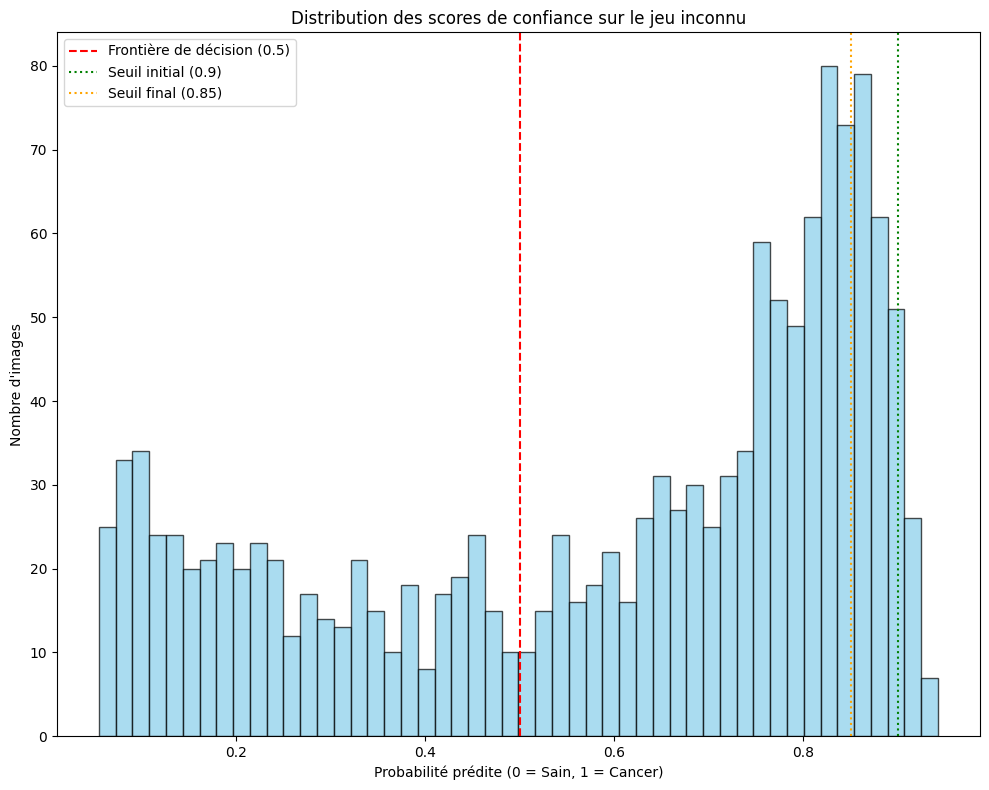

In [35]:
# from notebooks.utils.analyze_ssl import analyze_confidence
from notebooks.utils.plotting.make_model_plots import plot_confidence

all_unlabeled_probs = []
with torch.no_grad():
    for imgs, _, _ in uloader:
        logits = new_trainer.model(imgs.to(DEVICE))
        all_unlabeled_probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())

all_unlabeled_probs = np.array(all_unlabeled_probs)

plot_confidence(
    probas=all_unlabeled_probs,# results['raw_data']['probs'],
    threshold_range=list(decay),#type:ignore
    stats=True
)

In [ ]:
del (test_results, df_pseudo, all_unlabeled_probs, 
     trainer, model_classif, optimizer,
     new_model_classif, new_optimizer, new_trainer,
     udataset, uloader, test_loader, base_transform, 
     ssl_config, ssl_manager
    )
gc.collect()